In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import cv2
import glob
import shutil
import numpy as np
from tqdm import tqdm

ORIGINAL_IMAGE_DIR = '/content/drive/MyDrive/DL_FINAL/train/images'
ORIGINAL_LABEL_DIR = '/content/drive/MyDrive/DL_FINAL/train/labels'
AUG_IMAGE_DIR = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/images'
AUG_LABEL_DIR = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/labels'

os.makedirs(AUG_IMAGE_DIR, exist_ok=True)
os.makedirs(AUG_LABEL_DIR, exist_ok=True)

def read_yolo_labels(label_path):
    bboxes, class_labels = [], []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_labels.append(int(parts[0]))
                bboxes.append([float(x) for x in parts[1:]])
    return bboxes, class_labels

def save_yolo_labels(label_path, bboxes, class_labels):
    with open(label_path, 'w') as f:
        for cls, bbox in zip(class_labels, bboxes):
            f.write(f"{cls} {' '.join([str(round(x, 6)) for x in bbox])}\n")

def rotate_img_and_bboxes(img, bboxes, angle):
    h, w = img.shape[:2]
    center = (w / 2, h / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    img_rot = cv2.warpAffine(img, rot_mat, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    bboxes_rot = []
    for x, y, bw, bh in bboxes:
        x_abs = x * w
        y_abs = y * h
        coords = np.array([[x_abs, y_abs, 1]])
        x_rot, y_rot = np.dot(coords, rot_mat.T)[0][:2]
        x_new = np.clip(x_rot / w, 0, 1)
        y_new = np.clip(y_rot / h, 0, 1)
        bboxes_rot.append([x_new, y_new, bw, bh])
    return img_rot, bboxes_rot

def add_gaussian_noise(img, mean=0, std=10):
    noise = np.random.normal(mean, std, img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

def shear_img_and_bboxes(img, bboxes, shear_factor_x=0.1, shear_factor_y=0):
    h, w = img.shape[:2]
    M = np.float32([[1, shear_factor_x, 0],
                    [shear_factor_y, 1, 0]])
    img_sheared = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    bboxes_sheared = []
    for x, y, bw, bh in bboxes:
        x_abs = x * w
        y_abs = y * h
        x_shear = x_abs + shear_factor_x * y_abs
        y_shear = y_abs + shear_factor_y * x_abs
        x_new = np.clip(x_shear / w, 0, 1)
        y_new = np.clip(y_shear / h, 0, 1)
        bboxes_sheared.append([x_new, y_new, bw, bh])
    return img_sheared, bboxes_sheared

def letterbox_resize_with_padding(img, bboxes, target_size=640):
    h, w = img.shape[:2]
    scale = min(target_size/w, target_size/h)
    new_w, new_h = int(w*scale), int(h*scale)
    resized_img = cv2.resize(img, (new_w, new_h))
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    top, bottom = pad_h//2, pad_h - pad_h//2
    left, right = pad_w//2, pad_w - pad_w//2
    img_padded = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    bboxes_padded = []
    for x, y, bw, bh in bboxes:
        x_abs = x * w
        y_abs = y * h
        x_new = (x_abs * scale + left) / target_size
        y_new = (y_abs * scale + top) / target_size
        bw_new = bw * (w * scale) / target_size
        bh_new = bh * (h * scale) / target_size
        bboxes_padded.append([x_new, y_new, bw_new, bh_new])
    return img_padded, bboxes_padded

for image_path in glob.glob(os.path.join(ORIGINAL_IMAGE_DIR, '*.jpg')):
    filename = os.path.basename(image_path)
    shutil.copy2(image_path, os.path.join(AUG_IMAGE_DIR, filename))
    label_path = os.path.join(ORIGINAL_LABEL_DIR, filename.replace('.jpg', '.txt'))
    if os.path.exists(label_path):
        shutil.copy2(label_path, os.path.join(AUG_LABEL_DIR, filename.replace('.jpg', '.txt')))

for image_path in tqdm(glob.glob(os.path.join(ORIGINAL_IMAGE_DIR, '*.jpg')), desc="Augmenting"):
    filename = os.path.basename(image_path)
    img = cv2.imread(image_path)
    if img is None:
        continue
    label_path = os.path.join(ORIGINAL_LABEL_DIR, filename.replace('.jpg', '.txt'))
    if not os.path.exists(label_path):
        continue
    bboxes, class_labels = read_yolo_labels(label_path)

    # ROTATE +5
    img_rot5, bboxes_rot5 = rotate_img_and_bboxes(img, bboxes, 5)
    cv2.imwrite(os.path.join(AUG_IMAGE_DIR, filename.replace('.jpg', '_rot5.jpg')), img_rot5)
    save_yolo_labels(os.path.join(AUG_LABEL_DIR, filename.replace('.jpg', '_rot5.txt')), bboxes_rot5, class_labels)

    # ROTATE -5
    img_rotm5, bboxes_rotm5 = rotate_img_and_bboxes(img, bboxes, -5)
    cv2.imwrite(os.path.join(AUG_IMAGE_DIR, filename.replace('.jpg', '_rotm5.jpg')), img_rotm5)
    save_yolo_labels(os.path.join(AUG_LABEL_DIR, filename.replace('.jpg', '_rotm5.txt')), bboxes_rotm5, class_labels)

    # NOISE
    img_noise = add_gaussian_noise(img)
    cv2.imwrite(os.path.join(AUG_IMAGE_DIR, filename.replace('.jpg', '_noise.jpg')), img_noise)
    save_yolo_labels(os.path.join(AUG_LABEL_DIR, filename.replace('.jpg', '_noise.txt')), bboxes, class_labels)

    # SHEAR X
    img_shear, bboxes_shear = shear_img_and_bboxes(img, bboxes, shear_factor_x=0.15)
    cv2.imwrite(os.path.join(AUG_IMAGE_DIR, filename.replace('.jpg', '_shearx.jpg')), img_shear)
    save_yolo_labels(os.path.join(AUG_LABEL_DIR, filename.replace('.jpg', '_shearx.txt')), bboxes_shear, class_labels)

    # RESIZE
    img_letterbox, bboxes_letterbox = letterbox_resize_with_padding(img, bboxes, target_size=640)
    cv2.imwrite(os.path.join(AUG_IMAGE_DIR, filename.replace('.jpg', '_lbox.jpg')), img_letterbox)
    save_yolo_labels(os.path.join(AUG_LABEL_DIR, filename.replace('.jpg', '_lbox.txt')), bboxes_letterbox, class_labels)


Augmenting: 0it [00:00, ?it/s]


In [ ]:
import glob

image_folder = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/images'
image_count = len(glob.glob(f"{image_folder}/*.jpg"))
print(f"{image_folder} içinde {image_count} adet .jpg görüntü var.")


/content/drive/MyDrive/DL_FINAL/train/train_augmented/images içinde 5283 adet .jpg görüntü var.


In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os

IMAGE_DIR = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/images'
LABEL_DIR = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/labels'

removed_count = 0
for fname in os.listdir(IMAGE_DIR):
    if fname.endswith('.jpg'):
        label_file = os.path.join(LABEL_DIR, fname.replace('.jpg', '.txt'))
        image_file = os.path.join(IMAGE_DIR, fname)
        if not os.path.exists(label_file):
            os.remove(image_file)
            removed_count += 1
            print(f"Silindi: {fname} (etiketi yok)")

print(f"\nToplam {removed_count} etiketsiz görsel silindi.")


Silindi: 00360_115.jpg (etiketi yok)
Silindi: 00364_127.jpg (etiketi yok)
Silindi: 00360_126.jpg (etiketi yok)
Silindi: 00364_107.jpg (etiketi yok)
Silindi: 00360_120.jpg (etiketi yok)
Silindi: 00364_125.jpg (etiketi yok)
Silindi: 00360_122.jpg (etiketi yok)
Silindi: 00360_108.jpg (etiketi yok)
Silindi: 00360_114.jpg (etiketi yok)
Silindi: 00364_113.jpg (etiketi yok)
Silindi: 00364_119.jpg (etiketi yok)
Silindi: 00360_129.jpg (etiketi yok)
Silindi: 00364_120.jpg (etiketi yok)
Silindi: 00406_98.jpg (etiketi yok)
Silindi: 72 (12).jpg (etiketi yok)

Toplam 15 etiketsiz görsel silindi.


In [ ]:
import os
import glob
import shutil
import random

INPUT_IMAGE_DIR = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/images'
INPUT_LABEL_DIR = '/content/drive/MyDrive/DL_FINAL/train/train_augmented/labels'

TRAIN_IMAGE_OUT = '/content/drive/MyDrive/DL_FINAL/split/train/tr_images'
TRAIN_LABEL_OUT = '/content/drive/MyDrive/DL_FINAL/split/train/tr_labels'
VALID_IMAGE_OUT = '/content/drive/MyDrive/DL_FINAL/split/valid/vl_images'
VALID_LABEL_OUT = '/content/drive/MyDrive/DL_FINAL/split/valid/vl_labels'

for d in [TRAIN_IMAGE_OUT, TRAIN_LABEL_OUT, VALID_IMAGE_OUT, VALID_LABEL_OUT]:
    os.makedirs(d, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(INPUT_IMAGE_DIR, '*.jpg')))
random.seed(42)
random.shuffle(image_paths)

valid_image_paths = []
for img_path in image_paths:
    fname = os.path.basename(img_path)
    label_path = os.path.join(INPUT_LABEL_DIR, fname.replace('.jpg', '.txt'))
    if os.path.exists(label_path):
        valid_image_paths.append(img_path)

n_total = len(valid_image_paths)
n_train = int(n_total * 0.85)
n_valid = n_total - n_train

train_images = valid_image_paths[:n_train]
valid_images = valid_image_paths[n_train:]

print(f"Toplam {n_total} (label'ı olan) görsel bulundu.")
print(f"Train: {len(train_images)}, Valid: {len(valid_images)}")

for img_path in train_images:
    fname = os.path.basename(img_path)
    label_path = os.path.join(INPUT_LABEL_DIR, fname.replace('.jpg', '.txt'))
    shutil.copy2(img_path, os.path.join(TRAIN_IMAGE_OUT, fname))
    shutil.copy2(label_path, os.path.join(TRAIN_LABEL_OUT, fname.replace('.jpg', '.txt')))

for img_path in valid_images:
    fname = os.path.basename(img_path)
    label_path = os.path.join(INPUT_LABEL_DIR, fname.replace('.jpg', '.txt'))
    shutil.copy2(img_path, os.path.join(VALID_IMAGE_OUT, fname))
    shutil.copy2(label_path, os.path.join(VALID_LABEL_OUT, fname.replace('.jpg', '.txt')))

print("\nAyrım tamam! Sonuç:")
print(f"- Train görüntü: {len(os.listdir(TRAIN_IMAGE_OUT))}")
print(f"- Valid görüntü: {len(os.listdir(VALID_IMAGE_OUT))}")
print(f"- Train label:   {len(os.listdir(TRAIN_LABEL_OUT))}")
print(f"- Valid label:   {len(os.listdir(VALID_LABEL_OUT))}")


Toplam 5268 (label'ı olan) görsel bulundu.
Train: 4477, Valid: 791

Ayrım tamam! Sonuç:
- Train görüntü: 4477
- Valid görüntü: 791
- Train label:   4477
- Valid label:   791


In [ ]:
import os

IMG_DIR = '/content/drive/MyDrive/DL_FINAL/split/train/tr_images'
LBL_DIR = '/content/drive/MyDrive/DL_FINAL/split/train/tr_labels'

problemli = []
for fname in os.listdir(IMG_DIR):
    if fname.endswith('.jpg'):
        lblname = fname.replace('.jpg', '.txt')
        if not os.path.exists(os.path.join(LBL_DIR, lblname)):
            problemli.append(fname)

if len(problemli) == 0:
    print("Tüm görsellerin karşılığı label dosyası var!")
else:
    print(f"{len(problemli)} adet label'sız görsel var!")
    print(problemli)


Tüm görsellerin karşılığı label dosyası var!


In [ ]:
import os
import shutil

IMAGES_DIR = '/content/drive/MyDrive/DL_FINAL/split/train/tr_images'
LABELS_DIR = '/content/drive/MyDrive/DL_FINAL/split/train/tr_labels'

n_copied = 0
n_missing = 0

for fname in os.listdir(IMAGES_DIR):
    if fname.endswith('.jpg'):
        label_fname = fname.replace('.jpg', '.txt')
        src_label = os.path.join(LABELS_DIR, label_fname)
        dst_label = os.path.join(IMAGES_DIR, label_fname)
        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)
            n_copied += 1
        else:
            print(f"[UYARI] {label_fname} bulunamadı!")
            n_missing += 1

print(f"\nToplam {n_copied} label dosyası jpg’lerin yanına kopyalandı.")
if n_missing > 0:
    print(f"{n_missing} label bulunamadı!")



Toplam 4477 label dosyası jpg’lerin yanına kopyalandı.


In [ ]:
import yaml

yaml_dict = {
    'train': '/content/drive/MyDrive/DL_FINAL/split/train/tr_images',
    'val': '/content/drive/MyDrive/DL_FINAL/split/valid/vl_images',
    'test': '/content/drive/MyDrive/DL_FINAL/valid',
    'names': {
        0: 'negatif',
        1: 'pozitif'
    }
}

yaml_path = '/content/drive/MyDrive/DL_FINAL/brain.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_dict, f, default_flow_style=False, allow_unicode=True)

print(f"brain.yaml başarıyla oluşturuldu: {yaml_path}")


brain.yaml başarıyla oluşturuldu: /content/drive/MyDrive/DL_FINAL/brain.yaml


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="/content/drive/MyDrive/DL_FINAL/brain.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    lr0=0.001,
    lrf=0.01,
    patience=10,
    optimizer = "Adam",
    val=True,
    save=True,
    save_dir="/content/drive/MyDrive/DL_FINAL/runs",
)

print("Eğitim tamamlandı! Sonuçlar:", results)
model.save("/content/drive/MyDrive/DL_FINAL/brain.pt")
print("Model kaydedildi")

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/DL_FINAL/brain.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.

train: Scanning /content/drive/MyDrive/DL_FINAL/split/train/tr_images.cache... 4477 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4477/4477 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 4.8±5.3 ms, read: 0.4±0.4 MB/s, size: 8.7 KB)


val: Scanning /content/drive/MyDrive/DL_FINAL/split/valid/vl_images.cache... 791 images, 0 backgrounds, 0 corrupt: 100%|██████████| 791/791 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.61G      1.194      1.669      1.147          8        640: 100%|██████████| 560/560 [01:56<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


                   all        791        827      0.478      0.841      0.509       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.61G      1.114      1.283      1.097         11        640: 100%|██████████| 560/560 [01:42<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]

                   all        791        827      0.477      0.867      0.562      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.63G      1.088      1.216      1.084          4        640: 100%|██████████| 560/560 [01:43<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  7.00it/s]

                   all        791        827      0.492      0.891      0.587      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.63G       1.05      1.163      1.077          6        640: 100%|██████████| 560/560 [01:43<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]

                   all        791        827      0.534      0.873      0.671      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.63G      1.021      1.089      1.047          7        640: 100%|██████████| 560/560 [01:43<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]

                   all        791        827      0.559      0.844      0.719      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.63G      1.012      1.051      1.054          5        640: 100%|██████████| 560/560 [01:41<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]

                   all        791        827      0.648      0.794      0.787      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.65G      1.001      1.028      1.056         10        640: 100%|██████████| 560/560 [01:44<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.55it/s]

                   all        791        827      0.653      0.832      0.789      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.66G     0.9755     0.9647      1.037         11        640: 100%|██████████| 560/560 [01:43<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.68it/s]

                   all        791        827      0.642      0.849      0.802      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.68G      0.976     0.9501      1.036          5        640: 100%|██████████| 560/560 [01:43<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.65it/s]

                   all        791        827      0.665      0.852      0.814      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.68G     0.9536     0.8961      1.025          9        640: 100%|██████████| 560/560 [01:43<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.67it/s]

                   all        791        827      0.759      0.813      0.845      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.68G     0.9301     0.8681      1.015          9        640: 100%|██████████| 560/560 [01:45<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.52it/s]

                   all        791        827      0.756      0.835      0.869      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.68G     0.9169     0.8518      1.006          4        640: 100%|██████████| 560/560 [01:45<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

                   all        791        827      0.728      0.846      0.882      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.68G     0.9133     0.7945      1.004          5        640: 100%|██████████| 560/560 [01:44<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.47it/s]

                   all        791        827      0.802       0.87      0.899      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.68G     0.9121      0.779     0.9993         10        640: 100%|██████████| 560/560 [01:47<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.14it/s]

                   all        791        827      0.867      0.869      0.937      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.68G     0.8962     0.7523     0.9926         11        640: 100%|██████████| 560/560 [01:45<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.71it/s]

                   all        791        827      0.857      0.851      0.922       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.68G     0.8758      0.737     0.9848          5        640: 100%|██████████| 560/560 [01:50<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.19it/s]

                   all        791        827      0.859      0.869      0.928      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.68G     0.8636     0.6963     0.9844          7        640: 100%|██████████| 560/560 [01:45<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]

                   all        791        827      0.889      0.928      0.959      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.68G     0.8687      0.693     0.9889          9        640: 100%|██████████| 560/560 [01:46<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.64it/s]

                   all        791        827       0.88      0.904      0.958      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.68G     0.8472      0.664     0.9735          9        640: 100%|██████████| 560/560 [01:44<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.04it/s]

                   all        791        827      0.906      0.903      0.959      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.68G     0.8473     0.6469     0.9794         10        640: 100%|██████████| 560/560 [01:46<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]

                   all        791        827      0.911      0.936      0.962      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.68G     0.8409     0.6267     0.9758          4        640: 100%|██████████| 560/560 [01:43<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.56it/s]

                   all        791        827      0.938       0.96      0.983      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.68G     0.8269     0.5966      0.968          9        640: 100%|██████████| 560/560 [01:48<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.52it/s]

                   all        791        827      0.947      0.944      0.985      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.68G     0.8182     0.5936     0.9602          9        640: 100%|██████████| 560/560 [01:47<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.67it/s]

                   all        791        827       0.96      0.963      0.987      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.68G     0.8155     0.5652     0.9601          7        640: 100%|██████████| 560/560 [01:47<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.78it/s]

                   all        791        827      0.959      0.961      0.981      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.68G     0.7946     0.5641     0.9551         12        640: 100%|██████████| 560/560 [01:48<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.68it/s]

                   all        791        827      0.952      0.949       0.98      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.68G     0.7938     0.5542      0.958          9        640: 100%|██████████| 560/560 [01:48<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.73it/s]


                   all        791        827      0.964      0.971      0.987      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.68G     0.7928     0.5623     0.9515         10        640: 100%|██████████| 560/560 [01:44<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]

                   all        791        827      0.961      0.984      0.989      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.68G     0.7823      0.546     0.9461          4        640: 100%|██████████| 560/560 [01:48<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]

                   all        791        827      0.964      0.973      0.988      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.68G     0.7649     0.5144     0.9461         11        640: 100%|██████████| 560/560 [01:49<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]

                   all        791        827      0.977      0.985      0.992      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.68G     0.7504     0.5055     0.9406         10        640: 100%|██████████| 560/560 [01:47<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.84it/s]

                   all        791        827      0.983      0.987      0.992      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.68G     0.7628     0.4977     0.9421         11        640: 100%|██████████| 560/560 [01:47<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.59it/s]

                   all        791        827      0.966      0.972      0.991      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.68G     0.7432     0.4849     0.9337          8        640: 100%|██████████| 560/560 [01:46<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


                   all        791        827      0.987      0.981      0.992      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.68G     0.7443     0.4802     0.9386          7        640: 100%|██████████| 560/560 [01:48<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]

                   all        791        827      0.984      0.977      0.992       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.68G     0.7257     0.4693     0.9289          7        640: 100%|██████████| 560/560 [01:41<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]

                   all        791        827      0.989      0.978      0.993      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.68G     0.7151      0.456     0.9282         14        640: 100%|██████████| 560/560 [01:45<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.54it/s]


                   all        791        827      0.986      0.987      0.992      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.7G     0.7097     0.4496     0.9267          8        640: 100%|██████████| 560/560 [01:44<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.02it/s]

                   all        791        827      0.987      0.989      0.991      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       3.7G     0.7137     0.4418     0.9288         11        640: 100%|██████████| 560/560 [01:47<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.25it/s]

                   all        791        827      0.978      0.989      0.992      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.7G     0.7013     0.4333     0.9216         10        640: 100%|██████████| 560/560 [01:43<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]

                   all        791        827      0.989      0.988      0.993      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.7G     0.6894     0.4198     0.9215          7        640: 100%|██████████| 560/560 [01:45<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]

                   all        791        827      0.982      0.995      0.993      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.7G     0.6816      0.419     0.9129         12        640: 100%|██████████| 560/560 [01:44<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]

                   all        791        827      0.989      0.993      0.993      0.874


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.7G     0.5985     0.3304     0.8727          5        640: 100%|██████████| 560/560 [01:41<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]

                   all        791        827      0.991      0.989      0.993      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.7G     0.5801     0.3123     0.8662          5        640: 100%|██████████| 560/560 [01:38<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]

                   all        791        827      0.993      0.993      0.994      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.7G      0.569     0.3025     0.8587          6        640: 100%|██████████| 560/560 [01:36<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]

                   all        791        827      0.993      0.997      0.994      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.7G     0.5535     0.2971     0.8497          5        640: 100%|██████████| 560/560 [01:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.63it/s]

                   all        791        827      0.991      0.993      0.994      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       3.7G     0.5498     0.2901     0.8565          5        640: 100%|██████████| 560/560 [01:40<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.27it/s]

                   all        791        827      0.996      0.997      0.993      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.7G     0.5328     0.2804     0.8519          6        640: 100%|██████████| 560/560 [01:42<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.24it/s]

                   all        791        827      0.996      0.996      0.994      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       3.7G     0.5256     0.2763     0.8422          5        640: 100%|██████████| 560/560 [01:41<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.64it/s]

                   all        791        827      0.995      0.999      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       3.7G     0.5151     0.2719     0.8474          5        640: 100%|██████████| 560/560 [01:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]

                   all        791        827      0.994      0.996      0.993      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.7G     0.5023     0.2638     0.8401          7        640: 100%|██████████| 560/560 [01:38<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]

                   all        791        827      0.995          1      0.994      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       3.7G     0.4969     0.2636     0.8379          5        640: 100%|██████████| 560/560 [01:38<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:09<00:00,  5.18it/s]

                   all        791        827      0.997      0.999      0.994      0.904



50 epochs completed in 1.576 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:10<00:00,  4.59it/s]


                   all        791        827      0.997      0.999      0.994      0.904
               negatif        403        416      0.998      0.998      0.995       0.91
               pozitif        388        411      0.995          1      0.993      0.899
Speed: 0.4ms preprocess, 3.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train
Eğitim tamamlandı! Sonuçlar: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cde1ac65010>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,  

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 7.7±5.4 MB/s, size: 15.7 KB)


val: Scanning /content/drive/MyDrive/DL_FINAL/split/valid/vl_images.cache... 791 images, 0 backgrounds, 0 corrupt: 100%|██████████| 791/791 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


                   all        791        827      0.997      0.999      0.994      0.905
               negatif        403        416      0.998      0.998      0.995       0.91
               pozitif        388        411      0.995          1      0.993      0.899
Speed: 0.9ms preprocess, 3.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val10

=== SINIF BAZLI METRİK TABLOSU ===
   Sınıf  Precision   Recall mAP@0.5 mAP@0.5:0.95
 negatif   0.998000 0.998000                     
 pozitif   0.995000 1.000000                     
Ortalama   0.996703 0.998798   0.994        0.905

=== CONFUSION MATRIX ===
[[416   0]
 [  0 411]]

Accuracy (Doğruluk): 1.000


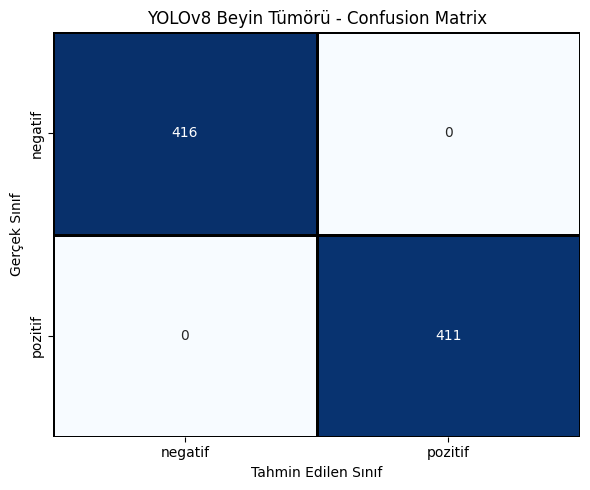

In [ ]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

model = YOLO("/content/drive/MyDrive/DL_FINAL/brain.pt")
results = model.val(data="/content/drive/MyDrive/DL_FINAL/brain.yaml", split="val")

class_names = list(results.names.values()) if isinstance(results.names, dict) else list(results.names)

metrics_data = {
    "Sınıf": class_names,
    "Precision": results.box.p,
    "Recall": results.box.r,
}

mean_row = {
    "Sınıf": "Ortalama",
    "Precision": np.mean(results.box.p),
    "Recall": np.mean(results.box.r),
}
df_metrics = pd.DataFrame(metrics_data)
df_metrics = df_metrics.round(3)
df_metrics = pd.concat([df_metrics, pd.DataFrame([mean_row])], ignore_index=True)
df_metrics["mAP@0.5"] = ""
df_metrics["mAP@0.5:0.95"] = ""
df_metrics.loc[df_metrics["Sınıf"] == "Ortalama", "mAP@0.5"] = f"{results.box.map50:.3f}"
df_metrics.loc[df_metrics["Sınıf"] == "Ortalama", "mAP@0.5:0.95"] = f"{results.box.map:.3f}"

print("\n=== SINIF BAZLI METRİK TABLOSU ===")
print(df_metrics.to_string(index=False))

confmat = results.confusion_matrix.matrix
confmat = confmat.astype(int)
confmat = confmat[:len(class_names), :len(class_names)]
accuracy = np.trace(confmat) / np.sum(confmat)

print("\n=== CONFUSION MATRIX ===")
print(confmat.astype(int))

print(f"\nAccuracy (Doğruluk): {accuracy:.3f}")

plt.figure(figsize=(6, 5))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, linewidths=2, linecolor='black')
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("YOLOv8 Beyin Tümörü - Confusion Matrix")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/DL_FINAL/confusion_matrix.png")
plt.show()



image 1/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (1).jpg: 640x640 2 pozitifs, 9.3ms
image 2/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (10).jpg: 640x640 1 pozitif, 31.8ms
image 3/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (100).jpg: 640x640 2 pozitifs, 17.3ms
image 4/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (101).jpg: 640x640 1 negatif, 7.8ms
image 5/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (102).jpg: 640x640 1 negatif, 1 pozitif, 7.4ms
image 6/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (103).jpg: 640x640 1 pozitif, 7.4ms
image 7/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (104).jpg: 640x640 1 negatif, 7.4ms
image 8/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (105).jpg: 640x640 1 pozitif, 7.3ms
image 9/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (106).jpg: 640x640 1 pozitif, 7.4ms
image 10/223 /content/drive/MyDrive/DL_FINAL/valid/images/val_1 (107).jpg: 640x640 1 pozitif, 7.

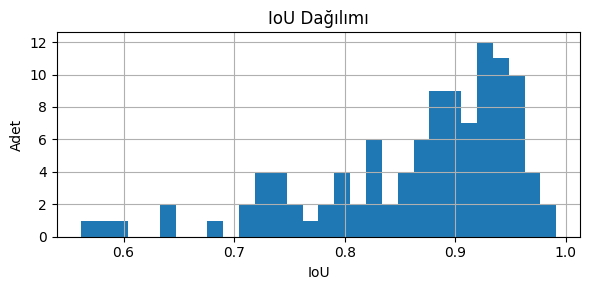

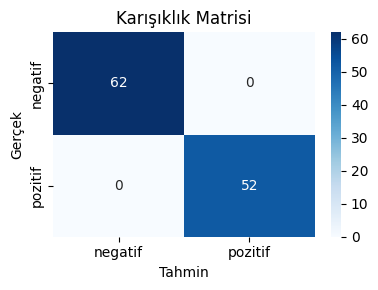

Ultralytics 8.3.150 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 25.0±26.9 MB/s, size: 52.5 KB)


val: Scanning /content/drive/MyDrive/DL_FINAL/split/valid/vl_images.cache... 791 images, 0 backgrounds, 0 corrupt: 100%|██████████| 791/791 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


                   all        791        827      0.997      0.999      0.994      0.905
               negatif        403        416      0.998      0.998      0.995       0.91
               pozitif        388        411      0.995          1      0.993      0.899
Speed: 1.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val11
mAP@0.5: 0.9939
mAP@0.5:0.95: 0.9046
Mean Precision: 0.9967
Mean Recall: 0.9988


In [ ]:
from ultralytics import YOLO
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

MODEL_PATH = "/content/drive/MyDrive/DL_FINAL/brain.pt"
IMG_DIR = "/content/drive/MyDrive/DL_FINAL/valid/images"
GT_DIR = "/content/drive/MyDrive/DL_FINAL/valid/labels"
OUT_DIR = "/content/drive/MyDrive/DL_FINAL/test_results"
os.makedirs(OUT_DIR, exist_ok=True)

class_names = ["negatif", "pozitif"]

model = YOLO(MODEL_PATH)
predict_results = model.predict(
    source=IMG_DIR,
    conf=0.5,
    save_txt=True,
    save_conf=True,
    save=False,
    project=OUT_DIR,
    name="predictions"
)
PRED_DIR = os.path.join(OUT_DIR, "predictions", "labels")

def load_yolo_txt(txt_path):
    results = []
    if not os.path.exists(txt_path):
        return []
    with open(txt_path, "r") as f:
        for line in f:
            vals = line.strip().split()
            vals = [float(x) for x in vals]
            if len(vals) == 6:
                class_id, x, y, w, h, conf = vals
            else:
                class_id, x, y, w, h = vals
                conf = 1.0
            results.append({'class': int(class_id), 'bbox': [x, y, w, h], 'conf': conf})
    return results

def xywh2xyxy(box, img_w, img_h):
    x_c, y_c, w, h = box
    x1 = (x_c - w/2) * img_w
    y1 = (y_c - h/2) * img_h
    x2 = (x_c + w/2) * img_w
    y2 = (y_c + h/2) * img_h
    return [x1, y1, x2, y2]

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB-xA) * max(0, yB-yA)
    if interArea == 0:
        return 0.0
    boxAArea = (boxA[2]-boxA[0]) * (boxA[3]-boxA[1])
    boxBArea = (boxB[2]-boxB[0]) * (boxB[3]-boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

image_paths = sorted(glob(os.path.join(IMG_DIR, "*.jpg")))
results = []

for img_path in image_paths:
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    gt_path = os.path.join(GT_DIR, img_name + ".txt")
    pred_path = os.path.join(PRED_DIR, img_name + ".txt")
    img = Image.open(img_path)
    w, h = img.size

    gt_boxes = load_yolo_txt(gt_path)
    pred_boxes = load_yolo_txt(pred_path)

    gt_xyxy = [xywh2xyxy(gt['bbox'], w, h) for gt in gt_boxes]
    pred_xyxy = [xywh2xyxy(pred['bbox'], w, h) for pred in pred_boxes]

    matches = []
    used_gt = set()
    used_pred = set()
    for i, gt in enumerate(gt_boxes):
        best_iou = 0
        best_j = -1
        for j, pred in enumerate(pred_boxes):
            if pred['class'] == gt['class']:
                iou_score = iou(gt_xyxy[i], pred_xyxy[j])
                if iou_score > best_iou:
                    best_iou = iou_score
                    best_j = j
        if best_iou > 0.5 and best_j != -1:
            matches.append((i, best_j))
            used_gt.add(i)
            used_pred.add(best_j)
            results.append({
                "image": img_name,
                "class": class_names[gt['class']],
                "true_positive": 1,
                "false_positive": 0,
                "false_negative": 0,
                "iou": best_iou,
                "confidence": pred_boxes[best_j]['conf']
            })
    for j, pred in enumerate(pred_boxes):
        if j not in used_pred:
            results.append({
                "image": img_name,
                "class": class_names[pred['class']],
                "true_positive": 0,
                "false_positive": 1,
                "false_negative": 0,
                "iou": 0,
                "confidence": pred['conf']
            })
    for i, gt in enumerate(gt_boxes):
        if i not in used_gt:
            results.append({
                "image": img_name,
                "class": class_names[gt['class']],
                "true_positive": 0,
                "false_positive": 0,
                "false_negative": 1,
                "iou": 0,
                "confidence": 0
            })

df = pd.DataFrame(results)
df.to_csv(os.path.join(OUT_DIR, "per_image_results.csv"), index=False)

summary = df.groupby("class")[["true_positive", "false_positive", "false_negative"]].sum()
summary["precision"] = summary["true_positive"] / (summary["true_positive"] + summary["false_positive"] + 1e-9)
summary["recall"] = summary["true_positive"] / (summary["true_positive"] + summary["false_negative"] + 1e-9)
summary["f1"] = 2 * summary["precision"] * summary["recall"] / (summary["precision"] + summary["recall"] + 1e-9)
summary.to_csv(os.path.join(OUT_DIR, "classwise_metrics.csv"))
print(summary)

plt.figure(figsize=(6,3))
df[df["iou"] > 0].iou.hist(bins=30)
plt.title("IoU Dağılımı")
plt.xlabel("IoU")
plt.ylabel("Adet")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "iou_histogram.png"))

all_classes = sorted(set(df["class"]))
cm = np.zeros((len(all_classes), len(all_classes)), dtype=int)
for img_path in image_paths:
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    gt_path = os.path.join(GT_DIR, img_name + ".txt")
    pred_path = os.path.join(PRED_DIR, img_name + ".txt")
    gt_boxes = load_yolo_txt(gt_path)
    pred_boxes = load_yolo_txt(pred_path)
    gt_cls = [gt['class'] for gt in gt_boxes]
    pred_cls = [pred['class'] for pred in pred_boxes]
    for gt in gt_cls:
        if gt in pred_cls:
            cm[gt, gt] += 1
            pred_cls.remove(gt)
        else:
            for c in range(len(all_classes)):
                if c == gt:
                    continue
                cm[gt, c] += 0
    for pred in pred_cls:
        cm[pred, pred] += 0

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "conf_matrix.png"))
plt.show()

metrics = model.val(data="/content/drive/MyDrive/DL_FINAL/brain.yaml", split="val")
mAP_05 = metrics.box.map50
mAP_095 = metrics.box.map
print(f"mAP@0.5: {mAP_05:.4f}")
print(f"mAP@0.5:0.95: {mAP_095:.4f}")
print(f"Mean Precision: {metrics.box.mp:.4f}")
print(f"Mean Recall: {metrics.box.mr:.4f}")
